In [29]:
import glob
import os
import random
from shutil import copyfile

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
random.seed(1337)
random_state = 451
np.random.seed(42)

In [30]:
model_vgg16 = VGG16(weights="imagenet", include_top=True)
feat_extractor_vgg16 = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer("fc2").output)

In [4]:
def extract_img_data(img_path, dimension=224):
    img = image.load_img(img_path, target_size=(dimension, dimension))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    return img_data

In [5]:
def features_from_VGG16(img_data):
    img_data = preprocess_input(img_data)
    features = feat_extractor_vgg16.predict(img_data)[0]
    features = np.array(features)
    return features

In [6]:
def extract_features(image_list, method="vgg16", limit=1000):
    image_list_cleaned = []
    image_list = image_list[:limit]
    features_list = []
    for img_path in image_list:
        try:
            img_data = extract_img_data(img_path)
            if method == "vgg16":
                features = features_from_VGG16(img_data)
            else:
                raise Exception("Unknown method")
        except:
            pass
        else:
            image_list_cleaned.append(img_path)
            features_list.append(features)
    return image_list_cleaned, features_list

In [7]:
def get_image_features(input_settings, method="vgg16"):
    image_list_final = []
    features_final = []
    
    for input_item in input_settings:
        # Get all image paths
        image_list = glob.glob(input_item["path"])

        # Randomize image list
        random.shuffle(image_list)
    
        # Extract features
        image_list_cleaned, features = extract_features(image_list, method, input_item["limit"])
    
        # Merge with final lists
        for img in image_list_cleaned:
            image_list_final.append({
              "path": img,
              "name": input_item["name"],
            })

        features_final = features_final + features
            
        print("Found {} images in {} folder with limit {}.".format(len(image_list_cleaned),
                                                                   input_item["name"],
                                                                   input_item["limit"]))
    return np.array(features_final), image_list_final

In [8]:
def get_pca(features, n_components=30):
    pca = PCA(n_components=n_components)
    pca.fit(features)
    return pca.transform(features)

In [9]:
def get_tsne(features, tsne_dimensions=2, tsne_perplexity=10, tsne_learning_rate=150):
    tsne = TSNE(n_components=tsne_dimensions,
                learning_rate=tsne_learning_rate,
                perplexity=tsne_perplexity,
                verbose=0)
    return tsne.fit_transform(features)

In [10]:
def normalize_points(original_points, dimensions=2):
    points = []
    for i, f in enumerate(original_points):
        point = [float(
                (original_points[i, k] - np.min(original_points[:, k])) / 
                (np.max(original_points[:, k]) - np.min(original_points[:, k])
            )) for k in range(dimensions)]
        points.append(point)
    return np.array(points)

In [11]:
def generate_collage(image_list, points, input_settings, dimension=1000, background_color=(255, 255, 255)):
    img_collage = Image.new("RGB", (dimension, dimension), background_color)
    
    # Merge points and images
    data = []
    for i, image in enumerate(image_list):
        data.append({
            "image": image,
            "point": points[i],
        })
    
    def paste_to_collage(data_list, filter_name, max_size):
        filtered = [k for k in data_list if k["image"]["name"] == filter_name]
        for i, item in enumerate(filtered):
            img = Image.open(item["image"]["path"])
            img.thumbnail([max_size, max_size], Image.ANTIALIAS)
            x = int(item["point"][0] * dimension)
            y = int(item["point"][1] * dimension)
            img_collage.paste(img, (x, y))
            
    # Background and foreground
    for input_item in input_settings:
        paste_to_collage(data,
                         input_item["name"],
                         input_item["max_size"])

    return img_collage

In [12]:
def sort_by_point(image_list, points):
    data = []
    for i, point in enumerate(points):
        data.append({
            "image": image_list[i],
            "point": point[0],
        })
    return sorted(data, key=lambda item: item["point"])

In [28]:
def copy_to_folder(export_list, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for index, item in enumerate(export_list):
        filename = os.path.splitext(os.path.basename(item["image"]["path"]))[0]
        copyfile(item["image"]["path"], "{}/{:06d}-{}-{}.jpg".format(folder_path,
                                                                     (index + 1),
                                                                     item["image"]["name"],
                                                                     filename))
    print("Copied {} files to '{}'".format(len(export_list), folder_path))

### Image processing methods

In [14]:
def generate_2d_collage(input_settings, output_img_dimension):
    features, image_list = get_image_features(input_settings, method="vgg16")
    
    pca = get_pca(features)
    tsne_points = get_tsne(pca, tsne_dimensions=2)
    points = normalize_points(tsne_points, dimensions=2)
    
    return generate_collage(image_list, points, input_settings, dimension=output_img_dimension)

In [15]:
def sort_images(input_settings):
    features, image_list = get_image_features(input_settings, method="vgg16")
    
    pca = get_pca(features)
    tsne_points = get_tsne(pca, tsne_dimensions=1)
    points = normalize_points(tsne_points, dimensions=1)
    
    return sort_by_point(image_list, points)

## 1.) GENERATE 2D COLLAGE

In [16]:
input_1 = [
    {
        "name": "primary",
        "path": "/users/adz/projects/zkm/dataset/original/**/*.jpg",
        "limit": 100,
        "max_size": 2000,
    },
    {
        "name": "secondary",
        "path": "/users/adz/projects/zkm/dataset/google/**/*.jpg",
        "limit": 100,
        "max_size": 500,
    }
]

dimension_1 = 25000

output_1 = "/users/adz/projects/zkm/export/output.tiff"

In [17]:
img_1 = generate_2d_collage(input_1, dimension_1)

Found 48 images in primary folder with limit 100.
Found 100 images in secondary folder with limit 100.


In [18]:
img_1.save(output_1, format="TIFF", compression="tiff_deflate")

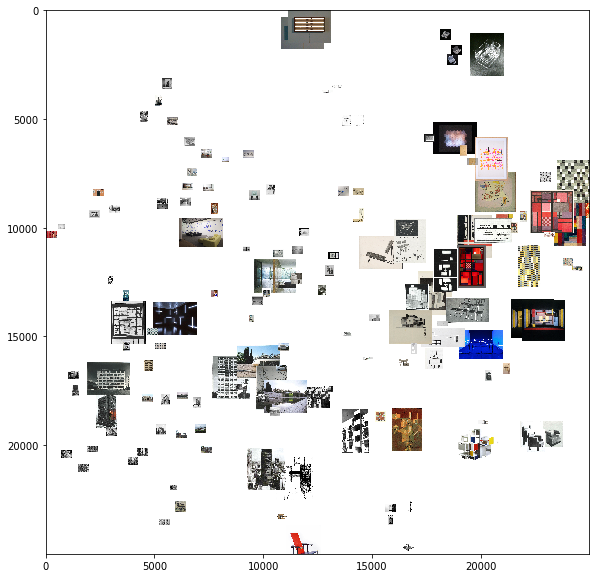

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(img_1, interpolation='nearest')

## 2.) SORT IMAGES (1D)

In [20]:
input_2 = [
    {
        "name": "primary",
        "path": "/users/adz/projects/zkm/dataset/original/**/*.jpg",
        "limit": 100,
    },
    {
        "name": "secondary",
        "path": "/users/adz/projects/zkm/dataset/google/**/*.jpg",
        "limit": 100,
    }
]

folder_path_2 = "/users/adz/projects/zkm/export/output-row"

In [21]:
sorted_points_2 = sort_images(input_2)
copy_to_folder(sorted_points_2, folder_path=folder_path_2)

Found 48 images in primary folder with limit 100.
Found 100 images in secondary folder with limit 100.
Copied 148 files to '/users/adz/projects/zkm/export/output-row'
